# Coursework I

This notebook describes the first part of the ML coursework (code).  This part builds on work that you have already done during the labs.  The purpose of this coursework, along with the previous lab work, is to:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- CW based on work that you did in the lab - don't use libraries that implement kNN or cross-validation.  We want to see your code!
- For more details, read the coursework PDF on learn.gold

In [38]:
# Load the IRIS dataset, as in the labs
%matplotlib inline


from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

#import k-nn classifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import operator


iris = datasets.load_iris()

#view a description of the dataset (uncomment next line to do so)
#print(iris.DESCR)

#Set X equal to features, Y equal to the targets

X=iris.data 
y=iris.target 


mySeed=1235612345#1234567
#initialize random seed generator 
np.random.seed(mySeed)

#we add some random noise to our data to make the task more challenging
#X=X+np.random.normal(0,0.5,X.shape)

## 1. Exploratory Data Analysis

In Lab 2, we discussed how the first part of tackling an ML problem is visualization, in order to understand some of the properties of the problem at-hand.  In the same lab, you were asked to reproduce a figure that plots pairs of features used in our problem.  Fill-in the code you used to plot this figure from Lab 2 in the cell below.  

You should create a function that given data X and labels y plots the 4x4 grid.  The function should be invoked as
    
    myplotGrid(X,y)
    
where X is your training data and y are the labels

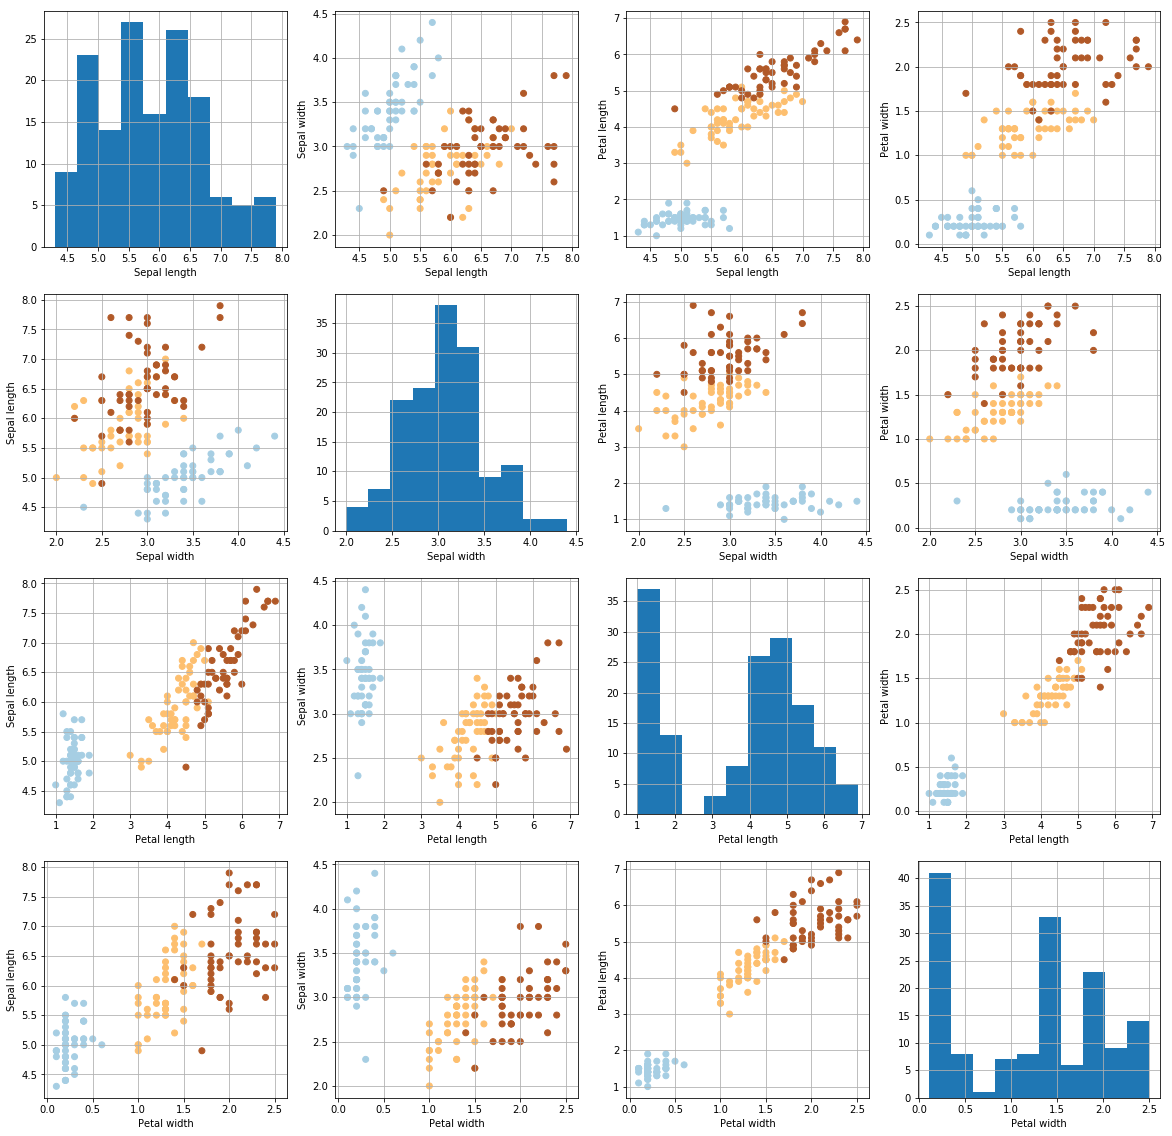

In [39]:
def myplotGrid(X,y):
    count=1
    fig=plt.figure(figsize=(20,20))

    for i in range (0,4):
        for j in range (0,4):
            cell=fig.add_subplot(4,4,count)
            if (i==0): cell.set_xlabel('Sepal length')
            count+=1
            if i==j :
                plt.hist(X[:,i])
                if (i==0): cell.set_xlabel('Sepal length')
                if (i==1): cell.set_xlabel('Sepal width')
                if (i==2): cell.set_xlabel('Petal length')
                if (i==3): cell.set_xlabel('Petal width')
            else :
                plt.scatter(X[:,i],X[:,j],c=y,cmap=plt.cm.Paired)
                if (i==0): cell.set_xlabel('Sepal length')
                if (i==1): cell.set_xlabel('Sepal width')
                if (i==2): cell.set_xlabel('Petal length')
                if (i==3): cell.set_xlabel('Petal width')
                if (j==0): cell.set_ylabel('Sepal length')
                if (j==1): cell.set_ylabel('Sepal width')
                if (j==2): cell.set_ylabel('Petal length')
                if (j==3): cell.set_ylabel('Petal width')
            plt.grid(True)
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings (e.g., from webcams or other errors) they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,


    np.random.seed(mySeed) # initialize random seed to replicate results over different runs
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

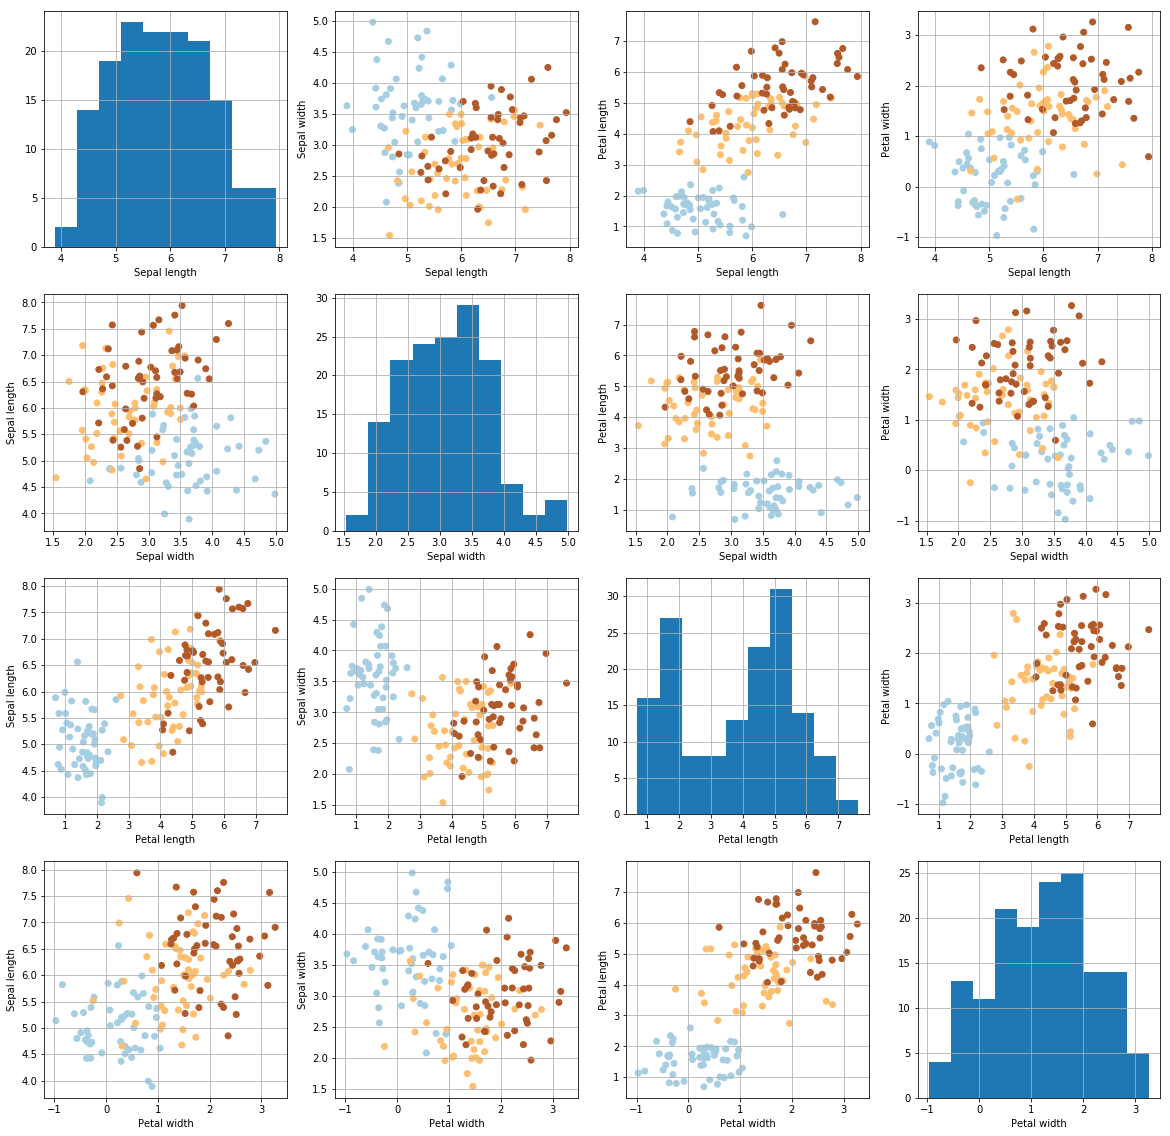

In [40]:
np.random.seed(mySeed) # initialize random seed to replicate results over different runs
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y)

## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You are guided to do this by following the notebook in Lab 4.  Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

In [41]:
np.random.seed(mySeed)

indices= np.random.permutation(X.shape[0]) 
bins=np.array_split(indices,2) # we  just need a training and testing set here
foldTrain=bins[0]
foldTest=bins[1]

## ANSWER HERE: Suggested code structure in comments below
# given a test point, your code should
# 
# - get the 'nearest neighbours' - i.e. the samples in the training set - that are nearest to our test sample
# -----> done by evaluating the distance of the test sample to all samples in the training set
# - assign a label to the test sample based on the 'neighbours'

##=== FUNCTION DEFINITIONS  ===##

#define distance functions: given two vectors (ndarrays), this function returns the distance between them
#Write at least two distance functions, measuring the squared distance between your data and the absolute value distance.
def euclideanVectors(in1,in2):
    return np.sqrt(np.sum(np.square(in1-in2)));
def manhattanVectors(in1,in2):
    return np.sum(np.absolute(in1-in2));
#You can implement both of these by looking at the numpy.linalg.norm method, or implement your own version.  

#The get neighbours function  returns the nearest neighbour indices in X of the test point x_.  In more detail
# Input: x_ : point in test data
#       X   : training data
#       n   : number of neighbours to return
#       T   : total number of training data
# Output: n-nearest neighbours of x_ in training data X

def getNeighbours(testing,training,neighbours,metric): # where T is number of data
    distances=np.empty(0,dtype=np.int8)
    if (metric=='euclidean'): 
        for i in range (0,training.shape[0]):
            distances=np.append(distances,euclideanVectors(training[i],testing))
    else: 
        for i in range (0,training.shape[0]):
            distances=np.append(distances,manhattanVectors(training[i],testing))
    indices=np.argsort(distances)

    if (neighbours>indices.shape[0]): 
        neighbours=indices.shape[0]
    closest=np.zeros(neighbours,dtype=np.int8)
    for n in range (0,neighbours):
        closest[n]=indices[n]
    return closest# indices of n-nearest neighbours in training data

# The assign label function returns the assigned label for a test data point, given the labels of nearest neighbours
# Input: nLabels : labels (classes) of nearest neighbours of a test point
# Output: the assigned label
# e.g., if we have n=1 (one neighbour), then we can just return the label of the nearest neighbour
# else, we can e.g., choose the majority class
def assignLabel(nLabels):
    #print('AL input: ',nLabels);
    if (len(nLabels)==1):
        return int(nLabels[0])
    #labels=np.zeros(len(np.unique(nLabels))) this throws an error when labels are 1 and 2 only
    highestLabel=int(np.unique(nLabels).max())+1
    #print ('AL uniques: ',np.unique(nLabels))
    #print ('AL highest label: ',highestLabel)
    labels=np.zeros(highestLabel,dtype=np.int8)
    maxLabel=0
    maxLabelInd=0
    for labelLoop in range (0,len(nLabels)):
        labels[nLabels[labelLoop]]+=1
        if (labels[nLabels[labelLoop]])>maxLabel:
            maxLabel=labels[nLabels[labelLoop]]
            maxLabelInd=nLabels[labelLoop]
    #print ('AL labels of neighbours: ',labels)
    labelIndex=maxLabelInd
    return labelIndex;# label assigned to test point x_

# here is some sample code for evaluating the kNN classifier you just built
# NOTE: this is just a suggested way to do this - you can do it in another way if you want
metric='euclidean'
NNmin=9
NNmax=10
assignLabelTest=np.array([0,2,0,2,2,1,1,0,1,2])
print('assignLabel test: ',assignLabelTest,' - ',assignLabel(assignLabelTest))
for NN in range (NNmin,NNmax):
    correct=0;
    for i in foldTest: #for all test points
        # knn classifier
        x_=X[i] # test point x_
        y_=y[i] # true label for y_
        print ('Test point: ',x_)
        knn=NearestNeighbors(n_neighbors=NN, metric=metric)
        knn.fit(X[foldTrain])
        defaultNeighbs=knn.kneighbors(x_.reshape(1,-1),return_distance=0)[0];
        print('Actual neighbour indexes in X: ',defaultNeighbs)
        
        
        # get neighbours of x_ in training data 
        tempTrain=np.zeros((len(foldTrain),4))
        for j in range (0,len(foldTrain)):
            tempTrain[j]=X[foldTrain[j]]
        neighbs=getNeighbours(x_,tempTrain,NN,metric)
        print('Predicted neighbour indexes in foldTrain: ',neighbs)
        distances=np.zeros(len(neighbs))
        for b in range (0, len(neighbs)):
            distances[b]=(euclideanVectors(X[foldTrain[int(neighbs[b])]],x_))
        print('Actual neighbour distances in X: ',knn.kneighbors(x_.reshape(1,-1))[0])
        print('Predicted neighbour distances in foldTrain: ',distances)


        # assignLabel to x_ based on neighbours
        neighbourLabels=np.zeros(NN,dtype=np.int8)
        for tempLabel in range (0,NN):
            neighbourLabels[tempLabel]=y[foldTest[neighbs[tempLabel]]]
        label=assignLabel(neighbourLabels)
        knn=KNeighborsClassifier(n_neighbors=NN, metric=metric)
        #define training and testing data, fit the classifier
        knn.fit(X[foldTrain],y[foldTrain])
        #predict values for test data based on training data
        truePred=knn.predict(X[foldTest])
        print('Neighbour labels: ', neighbourLabels)
        print('True neighbour labels: ',truePred[defaultNeighbs])
        
        print('Predicted label: ', label)
        print ('True label: ',y_)
        
        print(' ')
        # evaluate if the assigned label is correct (equal to y_)
        if (label==y_):
            correct+=1
        
    print ('Accuracy: ',correct/len(foldTest))

#condensed and standardised version of the above code
def myKNNise(training,labels,test,neighbours,metric):
    k_non=np.zeros(len(test),dtype=np.int8)
    for currentTest in range (0,len(test)): #for all test points
        # knn classifier
        point=test[currentTest] # test point x_
        
        # get neighbours of x_ in training data 
        neighbs=getNeighbours(point,training,neighbours,metric)
        neighbourLabels=np.zeros(neighbours,dtype=np.int8)
        for labelIndex in range (0,neighbours):
            neighbourLabels[labelIndex]=labels[neighbs[labelIndex]]
        # assignLabel to x_ based on neighbours
        predictedLabel=assignLabel(neighbourLabels)
        k_non[currentTest]=predictedLabel;
    return k_non;

assignLabel test:  [0 2 0 2 2 1 1 0 1 2]  -  2
Test point:  [ 5.6  2.7  4.2  1.3]
Actual neighbour indexes in X:  [23 16 62 61  4 65 59 73 42]
Predicted neighbour indexes in foldTrain:  [23 16 62 61  4 65 59 73 42]
Actual neighbour distances in X:  [[ 0.17320508  0.2236068   0.26457513  0.3         0.31622777  0.33166248
   0.37416574  0.41231056  0.50990195]]
Predicted neighbour distances in foldTrain:  [ 0.17320508  0.2236068   0.26457513  0.3         0.31622777  0.33166248
  0.37416574  0.41231056  0.50990195]
Neighbour labels:  [1 0 0 0 0 1 2 1 1]
True neighbour labels:  [1 0 0 0 0 1 2 1 1]
Predicted label:  0
True label:  1
 
Test point:  [ 5.   2.3  3.3  1. ]
Actual neighbour indexes in X:  [67 73 61 28 59 23 25  4 62]
Predicted neighbour indexes in foldTrain:  [67 73 61 28 59 23 25  4 62]
Actual neighbour distances in X:  [[ 0.64807407  0.87749644  0.93273791  0.9486833   1.2         1.21243557
   1.22474487  1.25698051  1.26095202]]
Predicted neighbour distances in foldTrain:  

Test point:  [ 5.   3.4  1.6  0.4]
Actual neighbour indexes in X:  [63 13 11 49  8 71 32 46 45]
Predicted neighbour indexes in foldTrain:  [63 13 11 49  8 71 32 58 46]
Actual neighbour distances in X:  [[ 0.2         0.2236068   0.26457513  0.28284271  0.31622777  0.41231056
   0.41231056  0.4472136   0.4472136 ]]
Predicted neighbour distances in foldTrain:  [ 0.2         0.2236068   0.26457513  0.28284271  0.31622777  0.41231056
  0.41231056  0.4472136   0.4472136 ]
Neighbour labels:  [1 2 1 0 0 2 0 2 1]
True neighbour labels:  [1 2 1 0 0 2 0 1 0]
Predicted label:  0
True label:  0
 
Test point:  [ 5.2  3.4  1.4  0.2]
Actual neighbour indexes in X:  [ 8 11 13 68 38 47 12 45 46]
Predicted neighbour indexes in foldTrain:  [ 8 11 13 68 38 47 12 58 46]
Actual neighbour distances in X:  [[ 0.14142136  0.17320508  0.2236068   0.33166248  0.33166248  0.34641016
   0.36055513  0.4472136   0.4472136 ]]
Predicted neighbour distances in foldTrain:  [ 0.14142136  0.17320508  0.2236068   0.3316624

Predicted neighbour indexes in foldTrain:  [53 56 27 20 18 74 36  5 29]
Actual neighbour distances in X:  [[ 0.38729833  0.42426407  0.46904158  0.48989795  0.54772256  0.6164414
   0.6164414   0.7         0.71414284]]
Predicted neighbour distances in foldTrain:  [ 0.38729833  0.42426407  0.46904158  0.48989795  0.54772256  0.6164414
  0.6164414   0.7         0.71414284]
Neighbour labels:  [2 0 0 1 1 1 2 1 1]
True neighbour labels:  [2 0 0 1 1 1 2 1 1]
Predicted label:  1
True label:  2
 
Test point:  [ 4.4  2.9  1.4  0.2]
Actual neighbour indexes in X:  [33 55 15 19  1 71 72 45 58]
Predicted neighbour indexes in foldTrain:  [33 55 15 19  1 71 72 46 58]
Actual neighbour distances in X:  [[ 0.14142136  0.3         0.34641016  0.36055513  0.42426407  0.46904158
   0.54772256  0.55677644  0.55677644]]
Predicted neighbour distances in foldTrain:  [ 0.14142136  0.3         0.34641016  0.36055513  0.42426407  0.46904158
  0.54772256  0.55677644  0.55677644]
Neighbour labels:  [0 2 0 2 1 2 2 

## 3. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above.  Again, you are guided to complete this task by following the appropriate notebook in Lab 4.  Your code for nested cross-validation should invoke your kNN function (see above).  You cross validation function should be invoked similary to:

    accuracy_fold=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan']`` evaluates the two distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should implement/validate at least two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each fold, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


==== Final Cross-val on test on fold  0  with NN 7 dist euclidean  accuracy  0.966666666667
Confusion matrix:
[[ 10.   0.   0.]
 [  0.  10.   1.]
 [  0.   0.   9.]]
==== Final Cross-val on test on fold  1  with NN 9 dist euclidean  accuracy  0.966666666667
Confusion matrix:
[[ 11.   0.   0.]
 [  0.   5.   1.]
 [  0.   0.  13.]]
==== Final Cross-val on test on fold  2  with NN 5 dist euclidean  accuracy  0.966666666667
Confusion matrix:
[[  8.   0.   0.]
 [  0.  14.   1.]
 [  0.   0.   7.]]
==== Final Cross-val on test on fold  3  with NN 5 dist euclidean  accuracy  1.0
Confusion matrix:
[[ 12.   0.   0.]
 [  0.  10.   0.]
 [  0.   0.   8.]]
==== Final Cross-val on test on fold  4  with NN 7 dist euclidean  accuracy  0.966666666667
Confusion matrix:
[[  9.   0.   0.]
 [  0.   8.   0.]
 [  0.   1.  12.]]
Accuracy per fold:  [ 0.96666667  0.96666667  0.96666667  1.          0.96666667]
Mean accuracy:  0.973333333333
Standard deviation:  0.0133333333333
==== Final Cross-val on test on fold

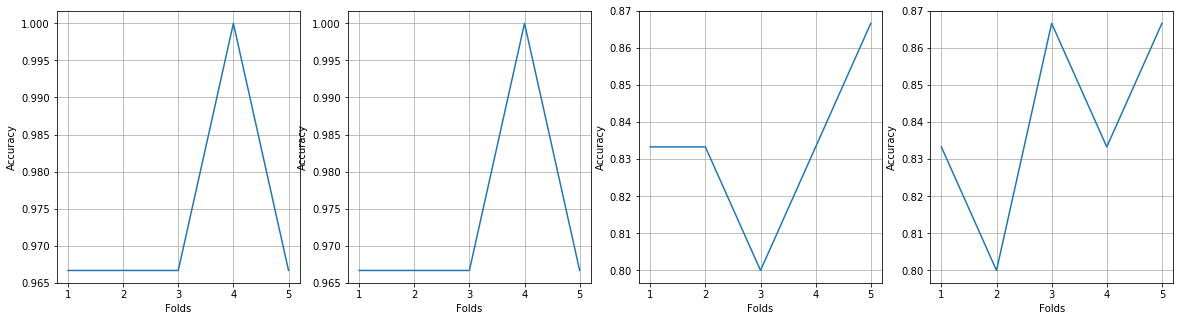

In [43]:
# nested cross validation function
# X - data / features
# y - outputs
# foldK - number of folds
# nns - list of number of neighbours parameter for validation
# dists - list of distances for validation
# mySeed - random seed
# returns: accuracy over 5 folds (list)

#debug knn using sklearn
def knnise(training,labels,test,neighbours,myMetric):
    knn=KNeighborsClassifier(n_neighbors=neighbours, metric=myMetric)
    
    #define training and testing data, fit the classifier
    knn.fit(training,labels)
    
    #predict values for test data based on training data
    k_non=knn.predict(test)
    return k_non;

def myAccuracy(testing,predicted):
    mistakes=0
    for i in range (len(testing)):
        if (testing[i]!=predicted[i]): mistakes+=1
    return 1-mistakes/len(testing);

#create a matrix with entries equal to zero, and subsequently build the confusion matrix
#the method should return the confusion matrix in a numpy array
def myConfMat(y_test,y_pred,classno):
    C=np.zeros((classno,classno)) # initialize the confusion matrix to zeros
    #loop through all results and update the confusion matrix
    for i in range (len(y_test)):
        C[y_test[i]][y_pred[i]]+=1
    return C

def myNestedCrossVal(X,y,foldK,nns,dists,mySeed,myTest=1):
    np.random.seed(mySeed)
    accuracy_fold=np.zeros(foldK)
    
    #TASK: use the function np.random.permutation to generate a list of shuffled indices from in the range (0,number of data)
    indices=np.random.permutation(np.arange(len(X)))
    
    #TASK: use the function array_split to split the indices to foldK different bins (here, 5)
    bins=np.split(indices,foldK)
    
    #no need to worry about this, just checking that everything is OK
    assert(foldK==len(bins))
    
    #loop through folds
    for foldNum in range(0,foldK):
        # list to save current indices for testing
        foldTest=bins[foldNum%foldK]  
        
        # list to save current indices for validation
        foldVal=bins[(foldNum+1)%foldK]    
        
        #loop through all bins, take bin i for testing, the next bin for validation and the rest for testing
        # list to save current indices for training
        foldTrain=np.delete(bins,[foldNum%foldK,(foldNum+1)%foldK],0).flatten()    
        
        #no need to worry about this, just checking that everything is OK
        assert not np.intersect1d(foldTest,foldVal)
        assert not np.intersect1d(foldTrain,foldTest)
        assert not np.intersect1d(foldTrain,foldVal)
       
        #save the best distance metric here
        bestDistance='' 
        #save the best number of neighbours here
        bestNN=-1 
        #save the best attained accuracy here (in terms of validation) 
        bestAccuracy=-10 
        
        # loop through all parameters (one for loop for distances, one for loop for nn)
        for distLoop in range (0,len(dists)):
            for neighLoop in range (0,len(nns)):
                
                # train the classifier on current number of neighbours/distance
                if (myTest):
                    val_pred=myKNNise(X[foldTrain],y[foldTrain],X[foldVal],nns[neighLoop],dists[distLoop])
                else:
                    val_pred=knnise(X[foldTrain],y[foldTrain],X[foldVal],nns[neighLoop],dists[distLoop])
                # obtain results on validation 
                currentAccuracy=myAccuracy(y[foldVal],val_pred)
                #print ('Fold ',foldNum,' Distance ',dists[distLoop],' Neighbours ',nns[neighLoop],' Accuracy ',currentAccuracy)
                
                # save parameters if results are the best we had
                if (currentAccuracy>bestAccuracy): 
                    bestAccuracy=currentAccuracy
                    bestDistance=dists[distLoop] 
                    bestNN=nns[neighLoop]
        #print('** End of val for this fold, best NN', bestNN, 'best Dist', bestDistance)
        #'''
        
        #evaluate on test data:
        #extend your training set by including the validation set             
        foldTrain=np.concatenate((foldTrain,foldVal),0)
        #train k-NN classifier on new training set and test on test set
        if (myTest):
            test_pred=myKNNise(X[foldTrain],y[foldTrain],X[foldTest],bestNN,bestDistance)
        else:
            test_pred=knnise(X[foldTrain],y[foldTrain],X[foldTest],bestNN,bestDistance)
        #get performance on fold, save result in accuracy_fold array
        accuracy_fold[foldNum]=myAccuracy(y[foldTest],test_pred)
        
        print('==== Final Cross-val on test on fold ',foldNum,' with NN', bestNN, 'dist', bestDistance, ' accuracy ',accuracy_fold[foldNum])
        print('Confusion matrix:')
        print(myConfMat(y[foldTest],test_pred,len(np.unique(y))))
    return accuracy_fold;
    
#call your nested crossvalidation function:
foldK=5
xAxis=np.arange(foldK)+1
accuracy_fold=myNestedCrossVal(X,y,foldK,list(range(1,11)),['euclidean','manhattan'],mySeed)

fig=plt.figure(figsize=(20,5))
cell=fig.add_subplot(1,4,1)
cell.set_xlabel('Folds')
cell.set_ylabel('Accuracy')
plt.plot(xAxis,accuracy_fold)
plt.grid(True)
print('Accuracy per fold: ',accuracy_fold)
print('Mean accuracy: ',np.mean(accuracy_fold))
print('Standard deviation: ',np.std((accuracy_fold)))

accuracy_fold=myNestedCrossVal(X,y,foldK,list(range(1,11)),['euclidean','manhattan'],mySeed,0)
cell=fig.add_subplot(1,4,2)
cell.set_xlabel('Folds')
cell.set_ylabel('Accuracy')
plt.plot(xAxis,accuracy_fold)
plt.grid(True)
print('Accuracy per fold: ',accuracy_fold)
print('Mean accuracy: ',np.mean(accuracy_fold))
print('Standard deviation: ',np.std((accuracy_fold)))

accuracy_fold=myNestedCrossVal(XN,y,foldK,list(range(1,11)),['euclidean','manhattan'],mySeed)

cell=fig.add_subplot(1,4,3)
cell.set_xlabel('Folds')
cell.set_ylabel('Accuracy')
plt.plot(xAxis,accuracy_fold)
plt.grid(True)
print('Noisy data:')
print('Accuracy per fold: ',accuracy_fold)
print('Mean accuracy: ',np.mean(accuracy_fold))
print('Standard deviation: ',np.std((accuracy_fold)))


accuracy_fold=myNestedCrossVal(XN,y,foldK,list(range(1,11)),['euclidean','manhattan'],mySeed,0)
cell=fig.add_subplot(1,4,4)
cell.set_xlabel('Folds')
cell.set_ylabel('Accuracy')
plt.plot(xAxis,accuracy_fold)
plt.grid(True)
print('Noisy data:')
print('Accuracy per fold: ',accuracy_fold)
print('Mean accuracy: ',np.mean(accuracy_fold))
print('Standard deviation: ',np.std((accuracy_fold)))
